In [1]:
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

STOCK = "TSLA"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx = mx.cpu()
mx.random.seed(1719)

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [5]:
import pandas as pd
dataset_ex_df = pd.read_csv('stock_dfs/{}.csv'.format(STOCK), header=0)

In [6]:
dataset_ex_df[['Date', STOCK]].head(3)

,Date,TSLA
0,2010-06-29,4.778000
1,2010-06-30,4.772000
2,2010-07-01,4.645333


In [7]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2575 number of days in the dataset.


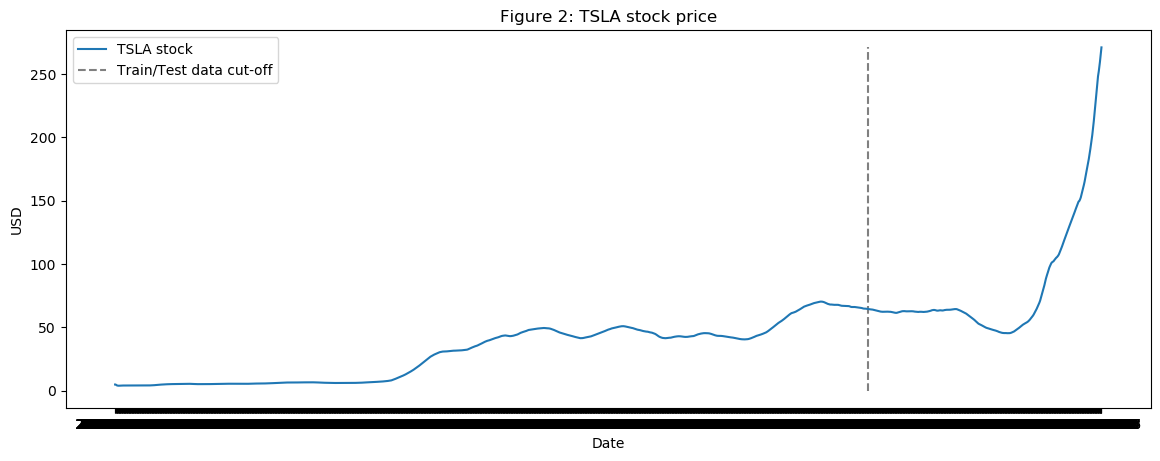

In [8]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['TSLA'], label='{} stock'.format(STOCK))
plt.vlines(str(datetime.date(2018,4, 20)), 0, max(dataset_ex_df[STOCK]), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: {} stock price'.format(STOCK))
plt.legend()
plt.show()

In [9]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1802. Number of test days: 773.


In [10]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset[STOCK].rolling(window=7).mean()
    dataset['ma21'] = dataset[STOCK].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = pd.DataFrame.ewm(dataset[STOCK], span=26).mean()
    dataset['12ema'] = pd.DataFrame.ewm(dataset[STOCK], span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset[STOCK].rolling(window=20,min_periods=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset[STOCK].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset[STOCK]-1
    
    return dataset

In [11]:
dataset_TI_df = get_technical_indicators(dataset_ex_df)


In [12]:
dataset_TI_df.tail()

,Unnamed: 0,Date,TSLA,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
2570,2570,2020-09-14,259.472799,252.350605,231.610831,227.463645,245.002800,17.539154,17.840838,267.292508,195.929154,258.178593,258.472799
2571,2571,2020-09-15,262.559139,254.791033,234.506814,230.063311,247.703775,17.640463,17.648796,269.804407,199.209222,261.098957,261.559139
2572,2572,2020-09-16,265.526439,257.266285,237.420631,232.690210,250.445723,17.755513,17.440611,272.301853,202.539409,264.050612,264.526439
2573,2573,2020-09-17,268.163239,259.859410,240.330588,235.317842,253.171495,17.853653,17.187612,274.705813,205.955364,266.792363,267.163239
2574,2574,2020-09-18,271.046499,262.556570,243.247923,237.964409,255.921495,17.957087,16.935911,277.119744,209.376101,269.628454,270.046499


In [13]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset[STOCK],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

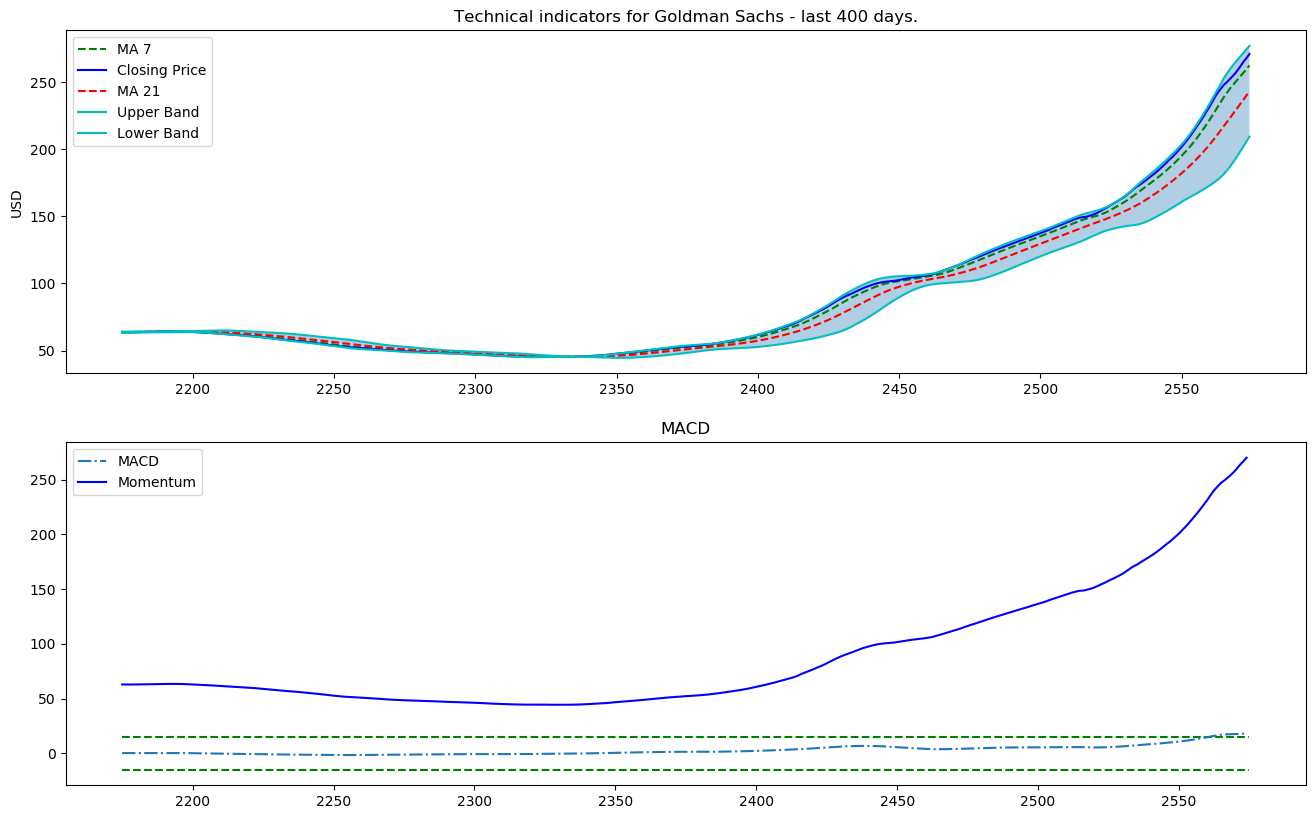

In [14]:
plot_technical_indicators(dataset_TI_df, 400)

In [15]:
data_FT = dataset_ex_df[['Date', STOCK]]

In [16]:
close_fft = np.fft.fft(np.asarray(data_FT[STOCK].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

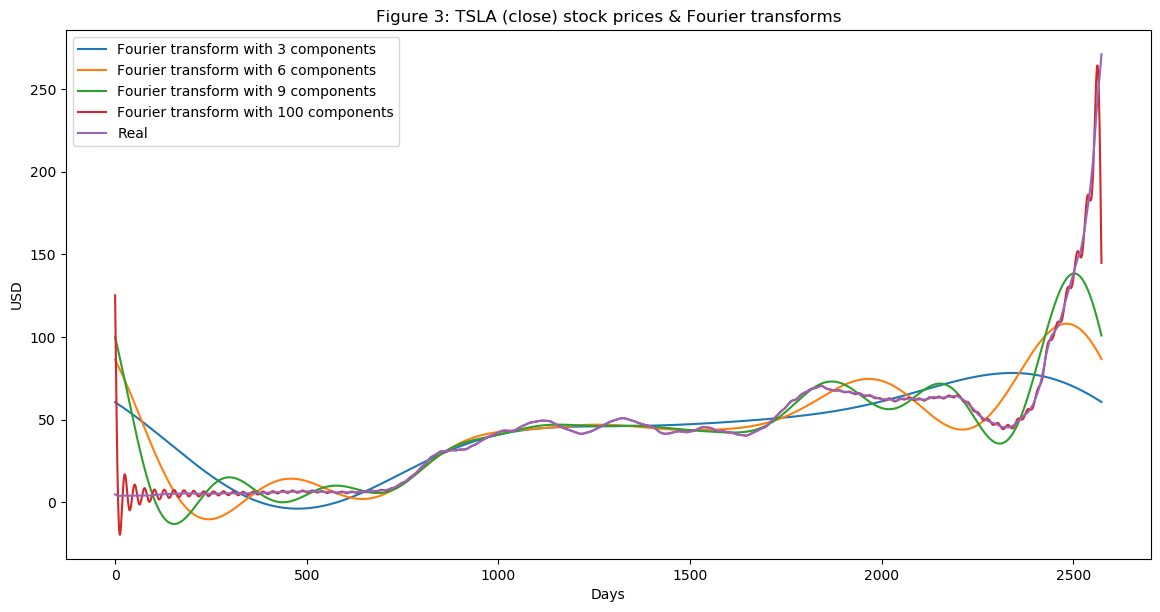

In [17]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT[STOCK],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: {} (close) stock prices & Fourier transforms'.format(STOCK))
plt.legend()
plt.show()

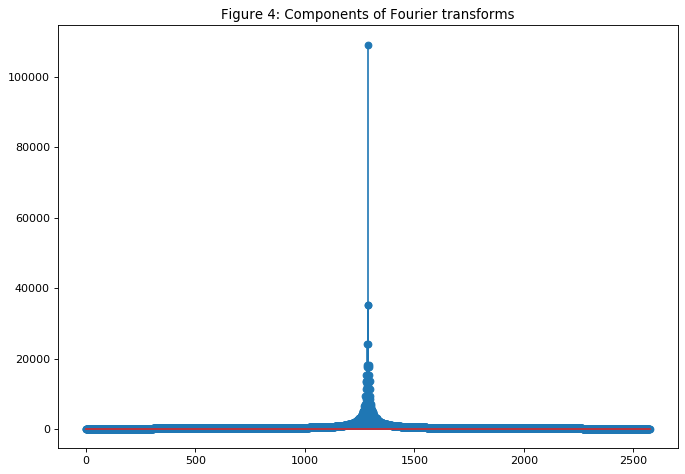

In [18]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [19]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT[STOCK]
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.TSLA   No. Observations:                 2574
Model:                 ARIMA(5, 1, 0)   Log Likelihood                4319.260
Method:                       css-mle   S.D. of innovations              0.045
Date:                Mon, 21 Sep 2020   AIC                          -8624.520
Time:                        15:57:40   BIC                          -8583.548
Sample:                             1   HQIC                         -8609.667
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.5742      0.640      0.897      0.370      -0.681       1.829
ar.L1.D.TSLA     0.9766      0.020     49.423      0.000       0.938       1.015
ar.L2.D.TSLA     0.0939      0.028      3.35

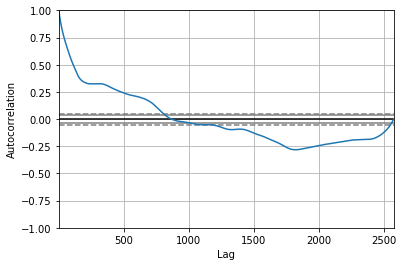

<Figure size 800x560 with 0 Axes>

In [20]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [21]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

/Users/luisguillermo/opt/anaconda3/envs/virtual_workspace/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/luisguillermo/opt/anaconda3/envs/virtual_workspace/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/luisguillermo/opt/anaconda3/envs/virtual_workspace/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/luisguillermo/opt/anaconda3/envs/virtual_workspace/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/luisguillermo/o

/Users/luisguillermo/opt/anaconda3/envs/virtual_workspace/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/luisguillermo/opt/anaconda3/envs/virtual_workspace/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/luisguillermo/opt/anaconda3/envs/virtual_workspace/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/luisguillermo/opt/anaconda3/envs/virtual_workspace/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/luisguillermo/opt/anaconda

In [22]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.006


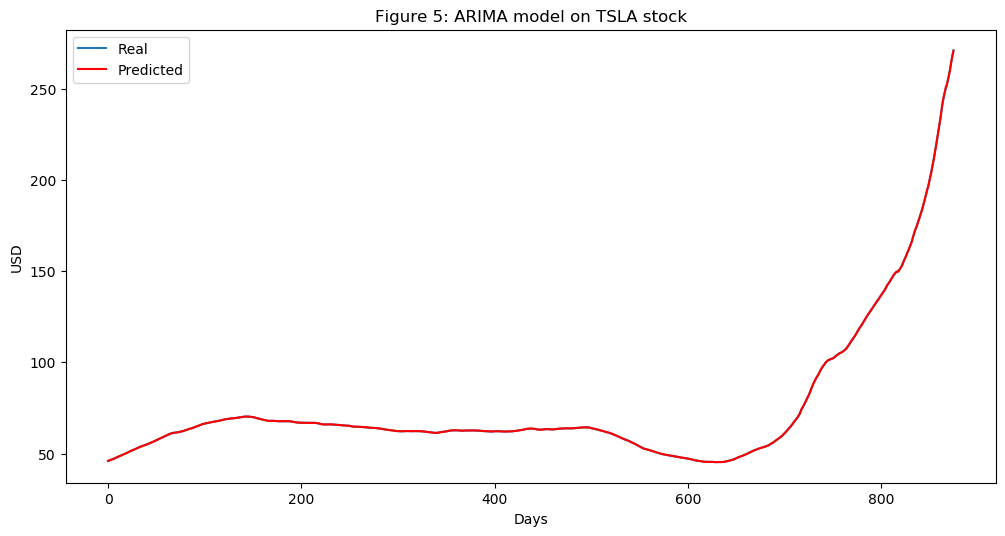

In [25]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on TSLA stock')
plt.legend()
plt.show()

In [26]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

NameError: name 'dataset_total_df' is not defined